# Intuit Quickbooks Upgrade

* Team-lead GitLab userid: juespino
* Group name: Team 17
* Team member names: Julian Espinoza-Martinez, Praveen Kumar Basker, Haritha Parupudi, William Quinn

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import qgrid
import statsmodels.formula.api as smf
from sklearn import metrics, preprocessing
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
#intuit75k.head()

In [3]:
# run python code from another notebook
#%run ./sub-notebooks/model1.ipynb

In [4]:
# importing functions from a module/package
from utils import functions

#functions.example()

In [5]:
print(f'Neural Networds Data Pre-processing\n')

Neural Networds Data Pre-processing



In [6]:
print(f'Before building and loading a neural network model, we will pre-process the data. To do so, with the addition of new zip code variables for 00801 and 00804, te conversion of the sex variables to dummies, the following variables were dropped: zip_bins & sincepurch.\n ')

Before building and loading a neural network model, we will pre-process the data. To do so, with the addition of new zip code variables for 00801 and 00804, te conversion of the sex variables to dummies, the following variables were dropped: zip_bins & sincepurch.
 


In [7]:
intuit75k = intuit75k.assign(
    zip801=(intuit75k["zip"] == "00801").astype(int),
    zip804=(intuit75k["zip"] == "00804").astype(int),
)
intuit75k["new_bins"] = rsm.xtile(intuit75k["zip_bins"], 10, rev=False)

In [8]:
break_even = 1.41 / 60

In [9]:
## Question answers
# setting up variables to track column names as needed
rvar = "res1_yes"
evar = [
    "sex",
    "bizflag",
    "version1",
    "owntaxprod",
    "zip801",
    "zip804",
    "upgraded",
]

std_evars = [
    "numords",
    "dollars",
    "last",
]

idvar = "id"
lev = 1

In [10]:
# storing results for evaluation of different models
train = intuit75k.loc[intuit75k["training"] == 1]
test = intuit75k.loc[intuit75k["training"] == 0]

X_train = train[evar]
y_train = train[rvar]
X_test = test[evar]
y_test = test[rvar]

In [11]:
eval_dat = pd.concat([train, test], axis=0)
eval_dat = eval_dat[[idvar, rvar, "training"]]

In [12]:
# standardization
X_colnames = intuit75k.loc[[0], "numords":"last"].columns
scaler = preprocessing.StandardScaler()
sf = scaler.fit(intuit75k.query("training == 1")[X_colnames])
int_std = intuit75k.copy()

# new standardized cols
int_std[std_evars] = sf.transform(intuit75k[X_colnames])

In [13]:
int_std_train = int_std.loc[int_std["training"] == 1]
int_std_test = int_std.loc[int_std["training"] == 0]

Xs_train = int_std_train[evar + std_evars]
Xs_test = int_std_test[evar + std_evars]

In [14]:
import warnings

warnings.filterwarnings("ignore")

In [15]:
# converting types of variables and creation of necessary dummy variables
#Xs_train["zip_bins"] = Xs_train["zip_bins"].astype("category")
Xs_train["version1"] = Xs_train["version1"].astype("category")
Xs_train["owntaxprod"] = Xs_train["owntaxprod"].astype("category")
Xs_train["bizflag"] = Xs_train["bizflag"].astype("category")
Xs_train["zip801"] = Xs_train["zip801"].astype("category")
Xs_train["zip804"] = Xs_train["zip804"].astype("category")
Xs_train["upgraded"] = Xs_train["upgraded"].astype("category")
#Xs_train["new_bins"] = Xs_train["new_bins"].astype("category")
# Xs_train["sex_Mail"] = Xs_trainXs_train["others"].astype("category")
# Xs_train["new_bins"] = intuit75k["new_bins"].astype("category")

# converting types of variables and creation of necessary dummy variables
#Xs_test["zip_bins"] = Xs_test["zip_bins"].astype("category")
Xs_test["version1"] = Xs_test["version1"].astype("category")
Xs_test["owntaxprod"] = Xs_test["owntaxprod"].astype("category")
Xs_test["bizflag"] = Xs_test["bizflag"].astype("category")
Xs_test["zip801"] = Xs_test["zip801"].astype("category")
Xs_test["zip804"] = Xs_test["zip804"].astype("category")
Xs_test["upgraded"] = Xs_test["upgraded"].astype("category")
#Xs_test["new_bins"] = Xs_test["new_bins"].astype("category")


In [16]:
Xs_train = pd.get_dummies(Xs_train[evar + std_evars])
Xs_test = pd.get_dummies(Xs_test[evar + std_evars])

In [17]:
# combining so we can predict for the full dataset as well
Xs = np.concatenate((Xs_train, Xs_test), axis=0)

In [18]:
print(f'After processing the data, to build the sklearn neural network, the activation used was relu and the solver was adam. Initially starting with 1 hidden layer, we adapted and changed to 3 hidden layers. The results of this neural network model can be seen below. \n')

After processing the data, to build the sklearn neural network, the activation used was relu and the solver was adam. Initially starting with 1 hidden layer, we adapted and changed to 3 hidden layers. The results of this neural network model can be seen below. 



In [19]:
# Neural net from SKLEARN
clf = MLPClassifier(
    activation="relu",
    solver="adam",
    alpha=0.01,
    hidden_layer_sizes=(3,),
    random_state=1234,
    max_iter=10000,
).fit(Xs_train, y_train)

In [20]:
eval_dat["y_nn"] = clf.predict_proba(Xs)[:, 1]
# eval_dat["y_nn"] = eval_dat["y_nn"] / 2

In [21]:
#eval_dat["mailto"] = eval_dat["y_nn"] > break_even
#eval_dat["mailto"].value_counts()

In [22]:
pred_2_tr = clf.predict_proba(Xs_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_2_tr[:, 1])

pred_2_test = clf.predict_proba(Xs_test)
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, pred_2_test[:, 1])

print(f"AUC training data for intial model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for intial model: {metrics.auc(fpr_t, tpr_t)}\n")

AUC training data for intial model: 0.7665061411955052
AUC testing data for intial model: 0.7617739728555164



In [23]:
# calculating the profit
# testing_set = eval_dat[eval_dat["training"] == 0]
# nn_prof = rsm.profit(
#     pred=pd.Series(testing_set["y_nn"]),
#     rvar=testing_set["res1_yes"],
#     lev=1,
#     cost=1.41,
#     margin=60,
# )
# nn_prof

In [24]:
# CV for NN
nr_hnodes = range(2, 5)
hls = list(zip(nr_hnodes)) + list(zip(nr_hnodes, nr_hnodes))
#hls

In [25]:
# alpha is the level of regularization
param_grid = {"hidden_layer_sizes": hls, "alpha": [0.001, 0.01, 0.05], "random_state": [1234]}
scoring = {"AUC": "roc_auc"}

clf_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5, 
)
clf_cv.fit(Xs_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.01, hidden_layer_sizes=(3,),
                                     max_iter=10000, random_state=1234),
             n_jobs=4,
             param_grid={'alpha': [0.001, 0.01, 0.05],
                         'hidden_layer_sizes': [(2,), (3,), (4,), (2, 2),
                                                (3, 3), (4, 4)],
                         'random_state': [1234]},
             refit='AUC', scoring={'AUC': 'roc_auc'}, verbose=5)

In [26]:
clf_cv.best_params_

{'alpha': 0.01, 'hidden_layer_sizes': (4, 4), 'random_state': 1234}

In [27]:
clf_cv.best_score_

0.769470774737468

In [28]:
print(f'\n')
print(f'After cross validating for neural networks to find the ideal hidden layers and alpha values, the best model had hidden layer size of (4,4) and alpha value of 0.01. The AUC scores for the following are shown below.\n')



After cross validating for neural networks to find the ideal hidden layers and alpha values, the best model had hidden layer size of (4,4) and alpha value of 0.01. The AUC scores for the following are shown below.



In [29]:
eval_dat["y_nn_cv"] = clf_cv.best_estimator_.predict_proba(Xs)[:, 1]
# eval_dat

In [30]:
#cv
#eval_dat['y_nn_cv'] = (eval_dat['y_nn'] + eval_dat['y_nn_cv'])/2
fpr, tpr, thresholds = metrics.roc_curve(y_train, eval_dat[eval_dat['training'] == 1]['y_nn_cv'])
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, eval_dat[eval_dat['training'] == 0]['y_nn_cv'])

print(f"AUC training data for adjusted trained model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for adjusted trained model: {metrics.auc(fpr_t, tpr_t)}\n")

AUC training data for adjusted trained model: 0.7730353075708837
AUC testing data for adjusted trained model: 0.7655718803158745



In [31]:
eval_dat["best_nn"] = (eval_dat["y_nn"] + eval_dat["y_nn_cv"]) / 2
# eval_dat

Commented out below for gitlab purposes.

In [32]:
# dct = {
#     "training": eval_dat[eval_dat.training == 1],
#     "test": eval_dat[eval_dat.training == 0],
# }
# rsm.evalbin(dct, "res1_yes", 1, ["y_nn", "y_nn_cv", "best_nn"], cost=1.41, margin=60)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,training,y_nn,2122,27216,22786,376,52500,0.849,0.456,0.072,0.133,0.474,0.050,85953.42,0.987,2.078,0.559,0.767
1,training,y_nn_cv,2215,30265,19737,283,52500,0.887,0.395,0.068,0.127,0.418,0.042,87103.20,1.000,1.902,0.619,0.773
2,training,best_nn,2172,28561,21441,326,52500,0.869,0.429,0.071,0.131,0.450,0.047,86986.47,0.999,2.007,0.585,0.771
3,test,y_nn,918,11799,9598,185,22500,0.832,0.449,0.072,0.133,0.467,0.047,37149.03,0.970,2.072,0.565,0.762
4,test,y_nn_cv,969,13103,8294,134,22500,0.879,0.388,0.069,0.128,0.412,0.040,38298.48,1.000,1.930,0.625,0.766
5,test,best_nn,947,12364,9033,156,22500,0.859,0.422,0.071,0.131,0.444,0.045,38051.49,0.994,2.027,0.592,0.765


In [33]:
# function for the lifts and gains plot
def plot(resp, model):
    # lift and gains plot
    w = 13
    h = 4
    d = 100
    fig = plt.figure(figsize=(w, h), dpi=d)
    fig.suptitle(f"Cumulative Lift and Gains For {model} Model")

    fig1 = fig.add_subplot(122)
    fig1.set_title("Cumulative Gains")
    fig1 = rsm.gains_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

    fig2 = fig.add_subplot(121)
    fig2.set_title("Cumulative Lift")
    fig2 = rsm.lift_plot(
        {
            "Training": eval_dat.query("training == 1"),
            "Test": eval_dat.query("training == 0"),
        },
        rvar="res1_yes",
        pred=resp,
        lev=1,
        qnt=10,
    )

In [34]:
def w2_profit(resp):
    # calculating the profit for wave-2 on test set
    breakeven = 1.41 / 60
    wave2_target = 763334
    eval_dat['mod_resp'] = eval_dat[resp] * 0.5
    eval_dat['mod_mail'] = eval_dat['mod_resp'] > breakeven
    df = eval_dat[eval_dat['training']==0]
    
    mail_true= sum(df['mod_mail']) #num of yes in test set
    mail_true_rate = mail_true / df.shape[0] #proportion to yes is test set
    buy_true = df[(df['mod_mail']==True) & (df['res1_yes']==1)] #true positives
    
    mail_number = wave2_target * mail_true_rate #customers to mail
    adjusted_rr = (buy_true.shape[0] * 0.5) / mail_true #adjusted buy rate
    wave2_buyers = adjusted_rr * mail_number #buyers in wave 2
   
    mail_cost = 1.41 * mail_number 
    profit = 60 * wave2_buyers - mail_cost
    rome = profit / mail_cost
    
    return profit,rome

In [35]:
print(f'The following cumulative lifts and gains plot also shows an absence of evident overfitting. And the profits for the wave 2 campaign and the scaled efforts are shown below.\n')

The following cumulative lifts and gains plot also shows an absence of evident overfitting. And the profits for the wave 2 campaign and the scaled efforts are shown below.



Wave-2 Scaled Campaign: The Profit is $448,543 and the the return on investment is 137.17% 



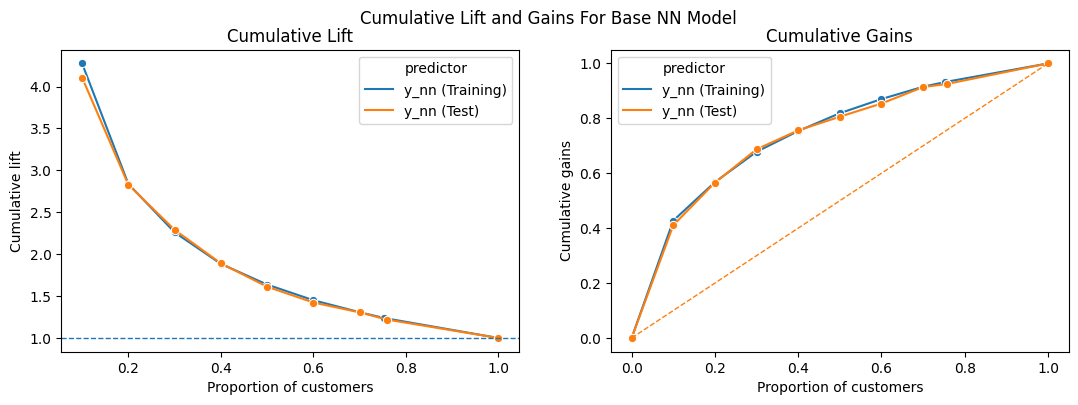

In [36]:
plot('y_nn', 'Base NN')
scaled_prof, scaled_rome = w2_profit("y_nn")

print(
    f"""Wave-2 Scaled Campaign (SKLearn Base): The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n"""
)

Wave-2 Scaled Campaign: The Profit is $453,127 and the the return on investment is 139.22% 



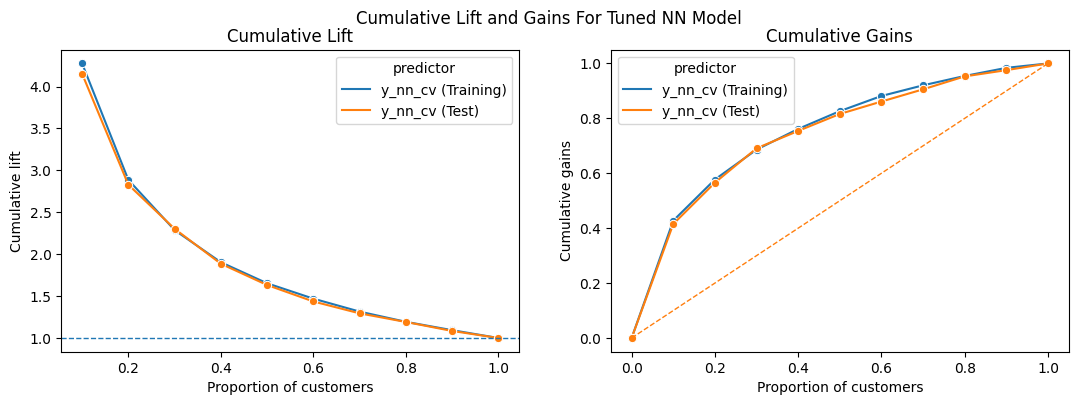

In [37]:
plot('y_nn_cv', 'Tuned NN')
scaled_prof, scaled_rome = w2_profit("y_nn_cv")

print(
    f"""Wave-2 Scaled Campaign (SKLearn Tuned): The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n"""
)

In [38]:
#ensemble
eval_dat['nn_ensemble'] = (eval_dat['y_nn'] + eval_dat['y_nn_cv'])/2
fpr, tpr, thresholds = metrics.roc_curve(y_train, eval_dat[eval_dat['training'] == 1]['nn_ensemble'])
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, eval_dat[eval_dat['training'] == 0]['nn_ensemble'])

print(f"AUC training data for sklearn neural network ensemble model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for sklearn neural network ensemble model: {metrics.auc(fpr_t, tpr_t)}")

AUC training data for intial model: 0.7712445545412772
AUC testing data for intial model: 0.7648546192599255


Wave-2 Scaled Campaign: The Profit is $447,177 and the the return on investment is 137.03% 




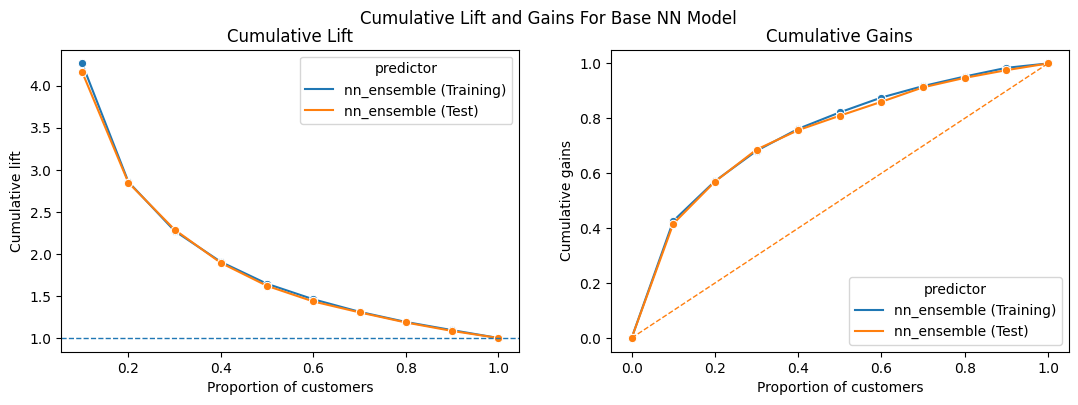

In [39]:
plot('nn_ensemble', 'Base NN')
scaled_prof, scaled_rome = w2_profit("nn_ensemble")

print(
    f"""Wave-2 Scaled Campaign (SKLearn Ensemble): The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n\n"""
)

In [40]:
print(f'We will continue onto build a Keras neural network model next.\n')

We will continue onto build a Keras neural network model next.



### Keras Model

In [41]:
KX_train = Xs_train
Ky_train = y_train

KX_test = Xs_test
Ky_test = y_test

In [42]:
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
import keras

In [43]:
predictors = KX_train.values
target = to_categorical(Ky_train)

In [44]:
n_cols = predictors.shape[1]

In [45]:
print(f'We will begin by building a base model with 2 hidden layers and to avoid overfitting, a dropout of 0.1 will also be used with 2 hidden layers, with units of 12 and 16 respectively.\n')

We will begin by building a base model with 2 hidden layers and to avoid overfitting, a dropout of 0.1 will also be used with 2 hidden layers, with units of 12 and 16 respectively.



In [46]:
model = Sequential()
model.add(Dense(3, activation="relu", input_shape=(n_cols,)))
model.add(Dropout(0.1))
model.add(Dense(12, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(2, activation="softmax"))

In [47]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(lr=2e-5), metrics=["accuracy"])

In [48]:
import random
random.seed(42)
model.fit(predictors, target, validation_split = 0.2, epochs = 25)

Epoch 1/25
1313/1313 [==============================] - 5s 3ms/step - loss: 0.5500 - accuracy: 0.9053 - val_loss: 0.4074 - val_accuracy: 0.9525
Epoch 2/25
1313/1313 [==============================] - 4s 3ms/step - loss: 0.3853 - accuracy: 0.9460 - val_loss: 0.2695 - val_accuracy: 0.9525
Epoch 3/25
1313/1313 [==============================] - 4s 3ms/step - loss: 0.2714 - accuracy: 0.9514 - val_loss: 0.2031 - val_accuracy: 0.9525
Epoch 4/25
1313/1313 [==============================] - 3s 3ms/step - loss: 0.2206 - accuracy: 0.9522 - val_loss: 0.1866 - val_accuracy: 0.9525
Epoch 5/25
1313/1313 [==============================] - 3s 2ms/step - loss: 0.2060 - accuracy: 0.9534 - val_loss: 0.1839 - val_accuracy: 0.9525
Epoch 6/25
1313/1313 [==============================] - 3s 3ms/step - loss: 0.2048 - accuracy: 0.9533 - val_loss: 0.1832 - val_accuracy: 0.9525
Epoch 7/25
1313/1313 [==============================] - 3s 2ms/step - loss: 0.2082 - accuracy: 0.9514 - val_loss: 0.1827 - val_accuracy:

In [49]:
eval_dat["y_kk"] = model.predict_proba(Xs)[:, 1]

In [50]:
print(f'To next check for the optimal architecture, I will run a check for epochs. And the results are below.\n')

To next check for the optimal architecture, I will run a check for epochs. And the results are below.



In [51]:
#Validation to determine optimal epochs
early_stopping_monitor = EarlyStopping(patience=2)
random.seed(42)
model.fit(
    predictors,
    target,
    validation_split=0.3,
    epochs=100,
    callbacks=[early_stopping_monitor],
)

eval_dat["y_kk_epochs"] = model.predict_proba(Xs)[:, 1]

Epoch 1/100
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1904 - accuracy: 0.9522 - val_loss: 0.1777 - val_accuracy: 0.9528
Epoch 2/100
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1920 - accuracy: 0.9522 - val_loss: 0.1776 - val_accuracy: 0.9528
Epoch 3/100
1149/1149 [==============================] - 3s 2ms/step - loss: 0.1899 - accuracy: 0.9522 - val_loss: 0.1775 - val_accuracy: 0.9528
Epoch 4/100
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1900 - accuracy: 0.9522 - val_loss: 0.1773 - val_accuracy: 0.9528
Epoch 5/100
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1903 - accuracy: 0.9522 - val_loss: 0.1773 - val_accuracy: 0.9528
Epoch 6/100
1149/1149 [==============================] - 3s 2ms/step - loss: 0.1900 - accuracy: 0.9522 - val_loss: 0.1772 - val_accuracy: 0.9528
Epoch 7/100
1149/1149 [==============================] - 3s 3ms/step - loss: 0.1904 - accuracy: 0.9522 - val_loss: 0.1772 - val_ac

In [52]:
ktrain = eval_dat[eval_dat["training"] == 1]
ktest = eval_dat[eval_dat["training"] == 0]

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, ktrain["y_kk"])
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, ktest["y_kk"])

print(f"AUC training data for intial model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for intial model: {metrics.auc(fpr_t, tpr_t)}")

AUC training data for intial model: 0.7021348729717745
AUC testing data for intial model: 0.7023191200705092


In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, ktrain["y_kk_epochs"])
fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test, ktest["y_kk_epochs"])

print(f"AUC training data for adjusted epochs model: {metrics.auc(fpr, tpr)}")
print(f"AUC testing data for adjusted epochs model: {metrics.auc(fpr_t, tpr_t)}")

AUC training data for adjusted epochs model: 0.7247139738109435
AUC testing data for adjusted epochs model: 0.7226908933226293


In [55]:
print(f'The cumulative lifts and gains plot below and the subsequent profit figures are for the wave-2 campaign and the scaled profits for the base keras model and the adjusted keras model with validation.\n')

The cumulative lifts and gains plot below and the subsequent profit figures are for the wave-2 campaign and the scaled profits for the base keras model and the adjusted keras model with validation.



Wave-2 Scaled Campaign: The Profit is $328,568 and the the return on investment is 80.87% 



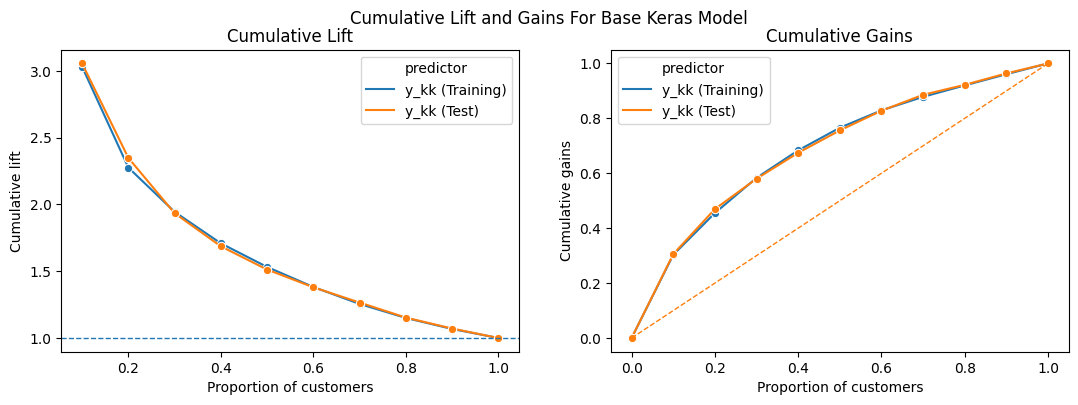

In [56]:
plot('y_kk', 'Base Keras')
scaled_prof, scaled_rome = w2_profit("y_kk")

print(
    f"""Wave-2 Scaled Campaign (Base Keras): The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n"""
)

Wave-2 Scaled Campaign: The Profit is $351,063 and the the return on investment is 77.85% 



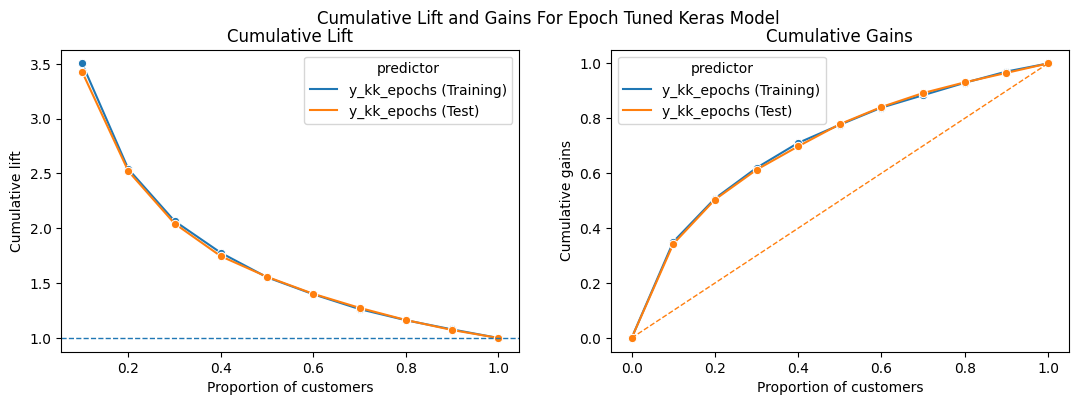

In [57]:
plot('y_kk_epochs', 'Epoch Tuned Keras')
scaled_prof, scaled_rome = w2_profit("y_kk_epochs")

print(
    f"""Wave-2 Scaled Campaign (Tuned Keras): The Profit is ${int(scaled_prof):,} and the the return on investment is {round(float(scaled_rome)*100,2):,}% \n"""
)

Cross validation commented out below for final submission.

In [58]:
#Keras CV
def get_model(units):
    model = Sequential()
    model.add(Dense(units, activation="relu", input_shape=(n_cols,)))
    model.add(Dropout(0.1))
    model.add(Dense(units, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(units, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(lr=2e-5), metrics=["accuracy"])
    return model

In [59]:
# CV FOR KERAS
# from keras.wrappers.scikit_learn import KerasClassifier
# units = [2, 4, 6]
# # create model
# for unit in units:
#     model_cv = KerasClassifier(build_fn=get_model(unit))
# # define the grid search parameters
# #batch_size = [10, 20, 40, 60, 80, 100]

# #param_grid = {"units": units, "epochs": [5, 10, 20]}
# scoring = {"AUC": "roc_auc"}

# grid_cv = GridSearchCV(estimator=model_cv, param_grid=param_grid, scoring = scoring,
#                         n_jobs=-1, cv=3, verbose = 5, refit = "AUC")

# summarize results
#grid_result = grid_cv.fit(predictors, target)
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [63]:
eval_dat.to_csv("./data/NN.csv", index=False)